This notebook provides examples of analysis of resting fMRI. 

To grab the data, you should first do the following:

bash ~/fmri-analysis-vm/get_resting.sh

This will grab 4 sessions of resting data from ses-105, along with the field maps for this session.  These data have been motion-corrected to a common target so that they are aligned to one another. The motion parameter files are derived separately from each session, rather than using the common target.

Credit:
- nilearn examples: https://nilearn.github.io/auto_examples/04_manipulating_images/plot_nifti_simple.html#sphx-glr-auto-examples-04-manipulating-images-plot-nifti-simple-py


In [6]:
import os,glob
import nibabel
import numpy
import sklearn
import nilearn.input_data
from nilearn.plotting import plot_roi
from nilearn.image.image import mean_img
from nilearn.plotting import plot_stat_map, show
from nilearn.image import index_img,clean_img
from nilearn.decomposition import CanICA

import matplotlib.pyplot as plt
from nipype.interfaces import fsl, nipy
from nipype.caching import Memory
mem = Memory(base_dir='.')

import sys
sys.path.append('/home/vagrant/fmri-analysis-vm/analysis/utils')
from compute_fd_dvars import compute_fd,compute_dvars

%matplotlib inline

Load the data, clean it, and compute a mask using the nilearn NiftiMasker function

In [7]:
rsfmri_basedir='/home/vagrant/data/ds031/sub-01/ses-105/mcflirt'
rsfmri_files=glob.glob(os.path.join(rsfmri_basedir,'sub*.nii.gz'))

rsfmri_files.sort()

# load the first image and create the masker object
rsfmri_img=nibabel.load(rsfmri_files[0])
masker= nilearn.input_data.NiftiMasker(mask_strategy='epi')
masker.fit(rsfmri_img)
mask_img = masker.mask_img_

rsfmri={}  # nifti handle to cleaned image
fmri_masked=None
# load and clean each image
for f in rsfmri_files:
    rsfmri_img=nibabel.load(f)
    runnum=int(f.split('_')[3].split('-')[1])
    rsfmri[runnum]=nilearn.image.clean_img(rsfmri_img)
    print('loaded run',runnum)
    motparfile=f.replace('nii.gz','par')
    mp=numpy.loadtxt(motparfile)
    if fmri_masked is None:
        fmri_masked=masker.transform(rsfmri[runnum])
        motpars=mp
    else:
        fmri_masked=numpy.vstack((fmri_masked,masker.transform(rsfmri[runnum])))
        motpars=numpy.vstack((motpars,mp))


loaded run 1
loaded run 2
loaded run 3
loaded run 4


Visualize the mask

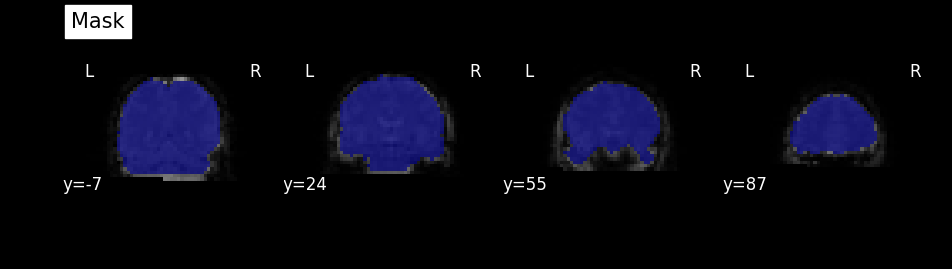

In [8]:
# calculate mean image for the background
mean_func_img = '/home/vagrant/data/ds031/sub-01/ses-105/mcflirt/mcflirt_target.nii.gz'

plot_roi(mask_img, mean_func_img, display_mode='y', 
         cut_coords=4, title="Mask")

Compute framewise displacement and plot it.

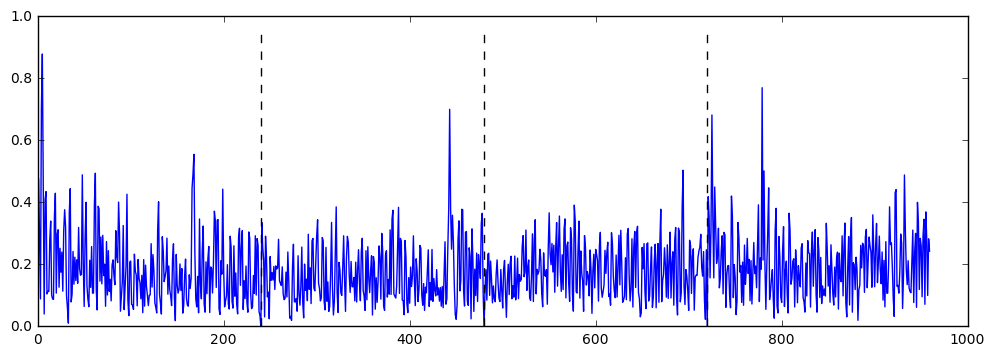

In [9]:
fd=compute_fd(motpars)
numpy.where(fd>1)
plt.figure(figsize=(12,4))
# remove first timepoint from each session
fd[240]=0
fd[480]=0
fd[720]=0
plt.plot(fd)
for c in [240,480,720]:
    plt.plot([c,c],
             [0,numpy.max(fd)*1.1],'k--')


Run ICA on the masked data, using the CanICA tool from nilearn.  Just arbitrarily set 10 components for now.

In [10]:
n_components=10

canica = CanICA(n_components=n_components, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(rsfmri_files)

# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)


[MultiNiftiMasker.fit] Loading data from [/home/vagrant/data/ds031/sub-01/ses-105/mcflirt/sub-01_ses-105_task-rest_run-001_bold_mcf.nii.gz, /home/vagrant/data/ds031/sub-01/ses-105/mcflirt/sub-01_ses-105_task-rest_run-002_bold_mcf.nii.gz, /ho
[MultiNiftiMasker.fit] Computing mask
[Memory]    0.0s, 0.0min: Loading compute_multi_epi_mask from nilearn_cache/joblib/nilearn/masking/compute_multi_epi_mask/ae6e74c9990abc60822c4b443c4e6454
______________________________compute_multi_epi_mask cache loaded - 0.0s, 0.0min
[MultiNiftiMasker.transform] Resampling mask
[Memory]    0.1s, 0.0min: Loading resample_img from nilearn_cache/joblib/nilearn/image/resampling/resample_img/c136ecb36b63b74dc023722ba869e75b
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]    0.1s, 0.0min: Loading filter_and_mask from nilearn_cache/joblib/nilearn/input_data/nifti_masker/filter_and_mask/12b980b302db1fa1774b2971dd047c61
_____________________________________filter_and_mask cach

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


_____________________________________________fastica cache loaded - 0.0s, 0.0min
[Memory]    5.0s, 0.1min: Loading unmask from nilearn_cache/joblib/nilearn/masking/unmask/a096eb942ca39afe26c2bcfd4ff8fde2
______________________________________________unmask cache loaded - 0.1s, 0.0min


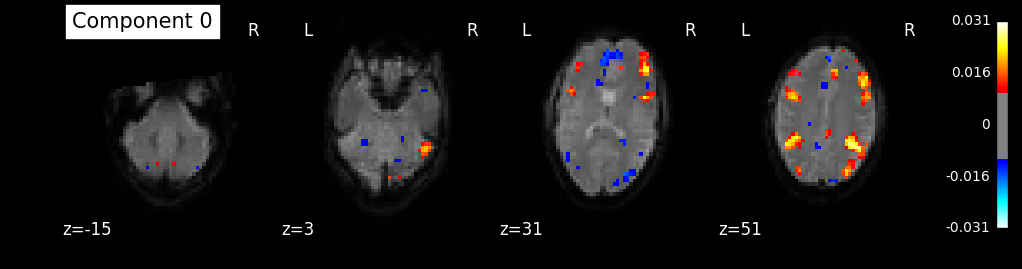

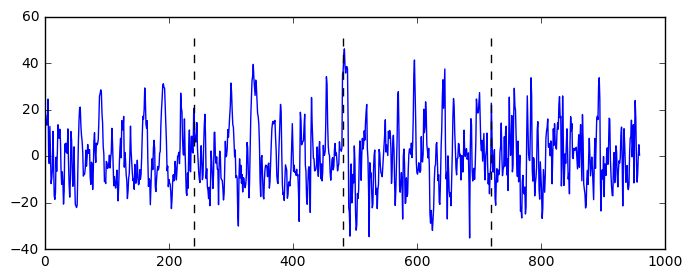

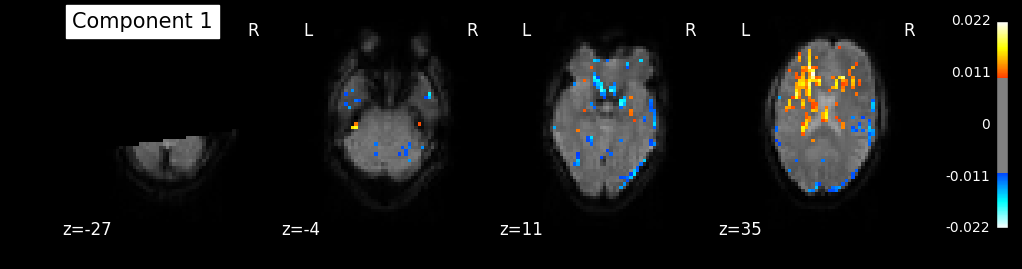

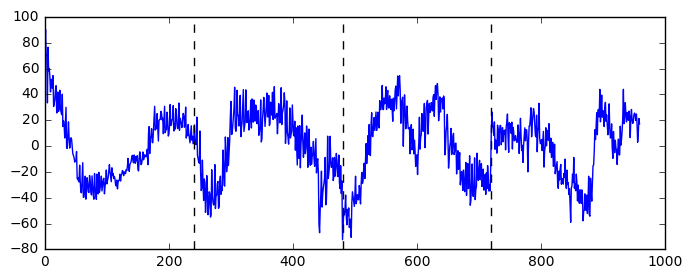

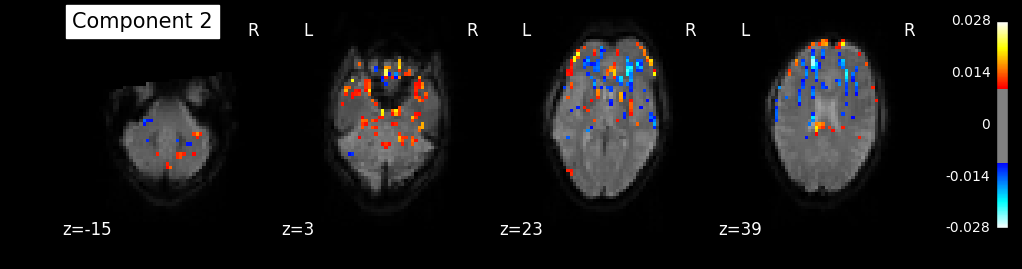

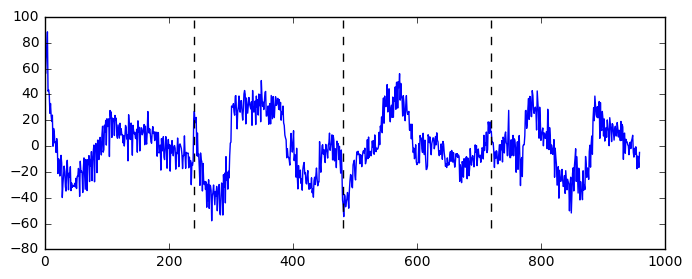

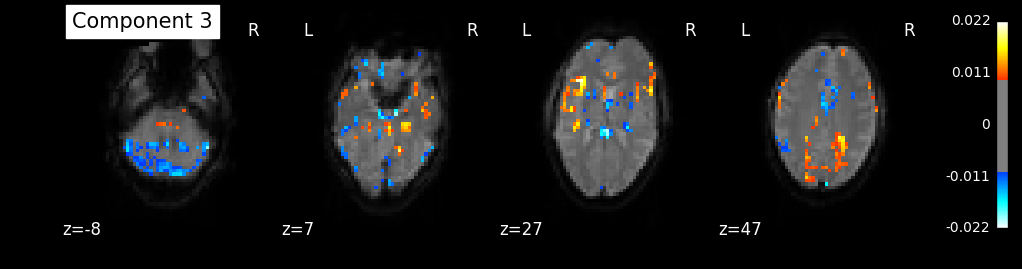

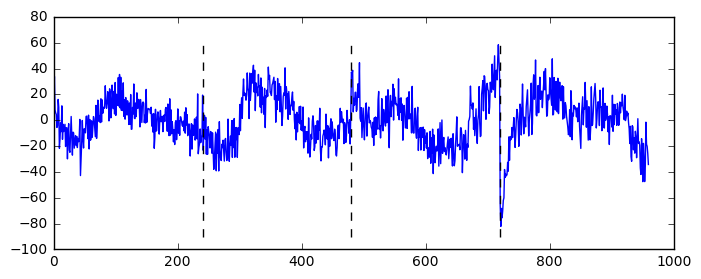

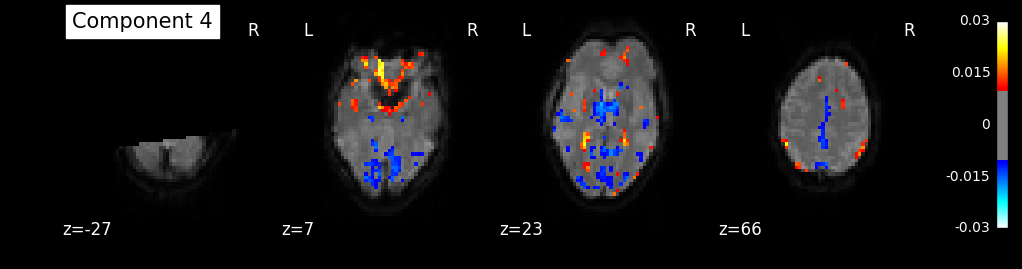

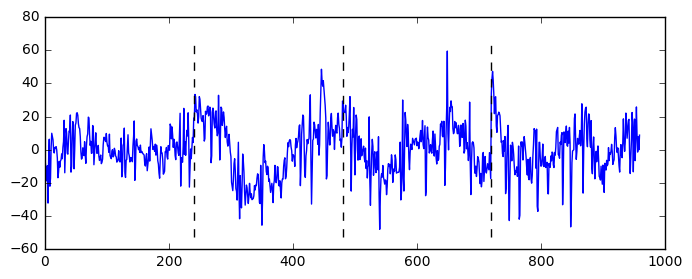

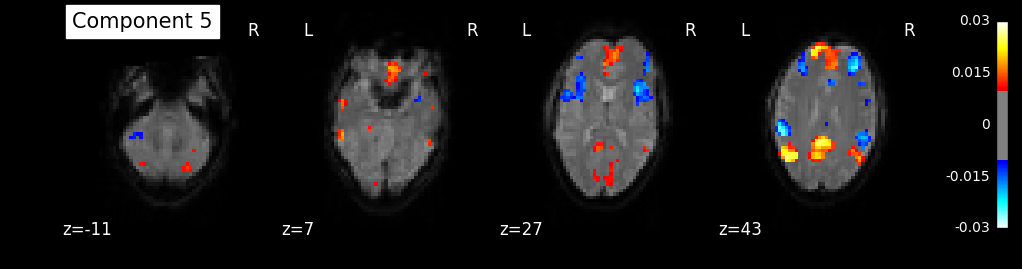

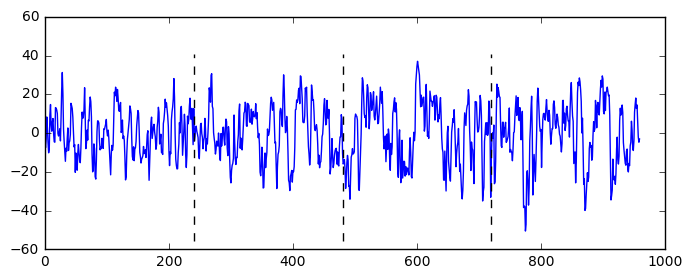

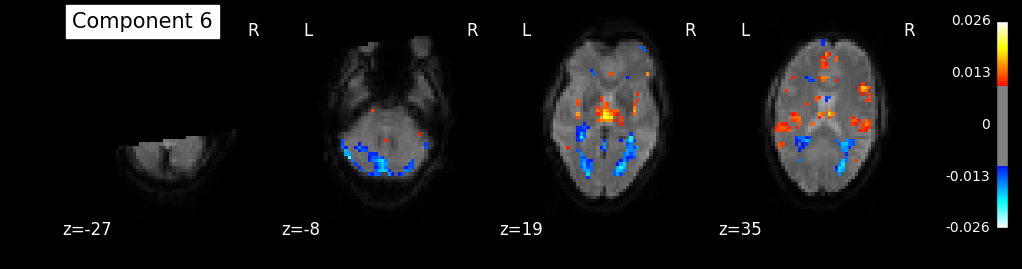

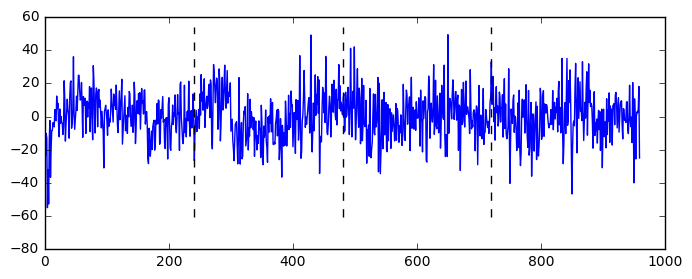

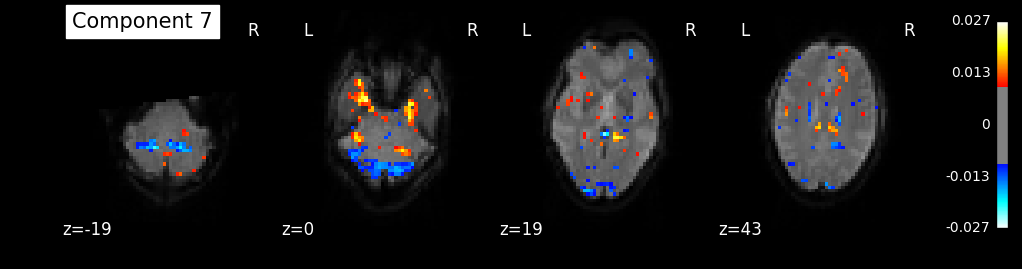

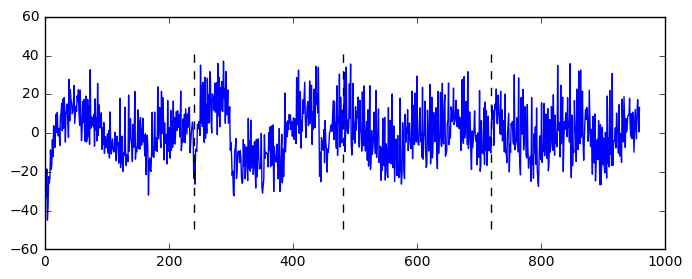

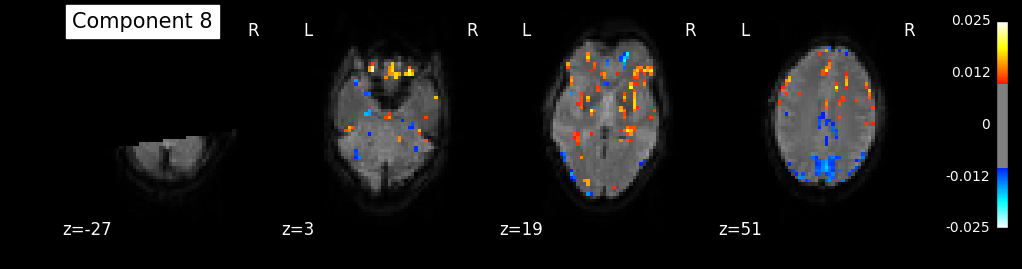

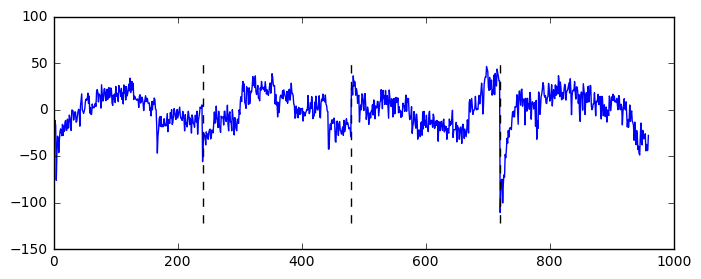

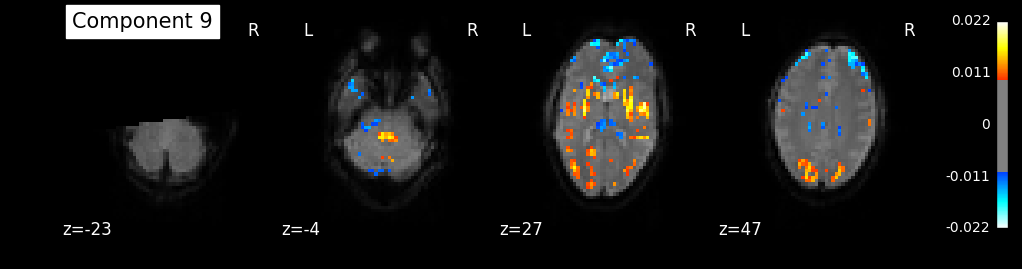

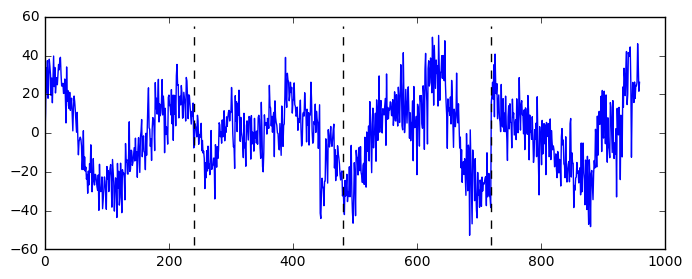

In [11]:
# Visualize results
for i in range(n_components):
    img=index_img(components_img, i)
    img_masked=masker.transform(img)
    ts=fmri_masked.dot(img_masked.T)
    plot_stat_map(img, mean_func_img,
              display_mode='z', cut_coords=4, threshold=0.01,
              title="Component %d"%i)
    plt.figure(figsize=(8,3))
    plt.plot(ts)
    for c in [240,480,720]:
        plt.plot([c,c],
                 [numpy.min(ts)*1.1,
                  numpy.max(ts)*1.1],
                'k--')
        


### Extracting a parcellated connectome

Next we will extract data from a set of atlas regions in order to calculate a connectome across regions.  First we need to align our data to the 2mm MNI space since the atlases from nilearn are in that space.  We already have our T1 image aligned to MNI, so we just need to align our EPI image to the T1 image.

In [14]:
# clean up memory
try:
    del canica
except:
    pass
try:
    del img_masked
except:
    pass
try:
    del components_img
except:
    pass
try:
    del rsfmri
except: 
    pass
try:
    del fmri_masked
except: 
    pass

datadir='/home/vagrant/data'
anat_subject='ses018'
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1file=os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')


# strip mean EPI
boldbet = mem.cache(fsl.BET)
bet_results = boldbet(functional=True,
              in_file=mean_func_img,
              mask=True)

# strip anatomy
t1bet = mem.cache(fsl.BET)
t1bet_results = t1bet(in_file=t1file,
              mask=True)

# EPIreg
epi_reg = mem.cache(fsl.EpiReg)
epi_reg_results = epi_reg(epi=bet_results.outputs.out_file,
                          t1_head=t1file,
                          t1_brain=t1bet_results.outputs.out_file,
                          out_base="epi2struct")


161121-20:51:25,760 workflow INFO:
	 Executing node e1bcc1a371fc16b52022eb04f3bcff7c in dir: /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-preprocess-BET/e1bcc1a371fc16b52022eb04f3bcff7c
161121-20:51:25,777 workflow INFO:
161121-20:51:25,805 workflow INFO:
	 Executing node cd5408d818ad7aae806526566d8e2c88 in dir: /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-preprocess-BET/cd5408d818ad7aae806526566d8e2c88
161121-20:51:25,818 workflow INFO:
161121-20:51:25,831 workflow INFO:
	 Executing node 6a8560d06bfd6ed5a8557b3203ce7aa0 in dir: /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/6a8560d06bfd6ed5a8557b3203ce7aa0
161121-20:51:25,834 workflow INFO:


In [20]:
for f in rsfmri_files:
    epi_to_t1 = mem.cache(fsl.FLIRT)
    epi_to_t1_results = epi_to_t1(in_file=f,
                                  reference=t1file,
                                  apply_xfm=True,
                                  in_matrix_file=epi_reg_results.outputs.epi2str_mat)

    t1_to_mni = mem.cache(ants.ApplyTransforms)
    t1_to_mni_results = t1_to_mni(input_image=epi_to_t1_results.outputs.out_file,
                                  reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                  transforms='../../results/t1_to_mni_warp.h5',
                                  interpolation="BSpline")
    t1_to_mni_results.outputs

161121-21:01:27,278 workflow INFO:
	 Executing node 4ae7b6ce0d0aeed7aab0070d537357a6 in dir: /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/4ae7b6ce0d0aeed7aab0070d537357a6
161121-21:01:27,286 workflow INFO:
	 Running: flirt -in /home/vagrant/data/ds031/sub-01/ses-105/mcflirt/sub-01_ses-105_task-rest_run-001_bold_mcf.nii.gz -ref /home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz -out sub-01_ses-105_task-rest_run-001_bold_mcf_flirt.nii.gz -omat sub-01_ses-105_task-rest_run-001_bold_mcf_flirt.mat -applyxfm -init /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/6a8560d06bfd6ed5a8557b3203ce7aa0/epi2struct.mat
161121-21:02:01,8 interface INFO:
	 stderr 2016-11-21T21:02:00.984931:Image Exception : #99 :: Out of memory
161121-21:02:01,677 interface INFO:
	 stderr 2016-11-21T21:02:01.677266:terminate called after throwing an instance of 'RBD_COMMON::BaseException'
161121-2

RuntimeError: Command:
flirt -in /home/vagrant/data/ds031/sub-01/ses-105/mcflirt/sub-01_ses-105_task-rest_run-001_bold_mcf.nii.gz -ref /home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz -out sub-01_ses-105_task-rest_run-001_bold_mcf_flirt.nii.gz -omat sub-01_ses-105_task-rest_run-001_bold_mcf_flirt.mat -applyxfm -init /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/6a8560d06bfd6ed5a8557b3203ce7aa0/epi2struct.mat
Standard output:

Standard error:
Image Exception : #99 :: Out of memory
terminate called after throwing an instance of 'RBD_COMMON::BaseException'
Aborted (core dumped)
Return code: 134
Interface FLIRT failed to run. 

In [17]:
epi_reg_results.outputs


epi2str_inv = <undefined>
epi2str_mat = /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/6a8560d06bfd6ed5a8557b3203ce7aa0/epi2struct.mat
fmap2epi_mat = <undefined>
fmap2str_mat = <undefined>
fmap_epi = <undefined>
fmap_str = <undefined>
fmapmag_str = <undefined>
fullwarp = <undefined>
out_1vol = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/6a8560d06bfd6ed5a8557b3203ce7aa0/epi2struct.nii.gz
shiftmap = <undefined>
wmedge = /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/6a8560d06bfd6ed5a8557b3203ce7aa0/epi2struct_fast_wmedge.nii.gz
wmseg = /home/vagrant/fmri-analysis-vm/analysis/resting/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/6a8560d06bfd6ed5a8557b3203ce7aa0/epi2struct_fast_wmseg.nii.gz